<a href="https://colab.research.google.com/github/pena-rodrigo/golombCA1/blob/main/param_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sbi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53670 sha256=a2eff462e3414635f740fd2af1e066a178494f8d88972d1c885a947b66877a96
  Stored in directory: /root/.cache/pip/wheels/3b/88/52/cbd4ed0597b48916de3de19b28d7297c72595f56085068c772
Successfully built nflows


In [3]:
import numpy as np
from scipy import stats as spstats
from scipy.signal import find_peaks
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [4]:
#@title Mount drive
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/param_estim'

dataload = np.loadtxt(f"{images_dir}/v_trials.dat")  

Mounted at /content/gdrive


In [5]:
#@title HHca2
class HHca2:
    """Golomb model with Ca + second compartment with I_h"""
    nid=0 #default neuron id
    sendspk=0
    
    C = 1.
    Gl=0.05
    Vl = -70.
    Gna = 35.
    Gnap = 0.3 #varies between 0 and 0.41 mS/cm2
    thetam = -30.
    deltam = 9.5
    Vna = 55.
    Gkdr = 6.
    thetah = -45.
    deltah = -7.
    thetaht= -40.5
    deltaht= -6.
    Vk = -90.
    thetap = -41. #-47#-41 #varies between -47mV and -41mV
    deltap = 3.
    thetan = -35.
    deltan = 10.
    thetant =-27.
    deltant=-15.
    Ga = 1.4
    thetaa = -50.
    deltaa = 20.
    taub = 15.
    thetab = -80.
    deltab = -6.
    Gm = 1.
    tauz = 75.
    thetaz = -39.
    deltaz = 5.
    
    Gca = 0.2#0.#0*0.2 #varies between 0 and 0.2 mS/cm2
    Gc = 10.
    Gsahp = 5.
    Vca = 120.
    thetar=-20.
    deltar=10.
    taur=1.
    thetac=-30.
    deltac=7.
    tauc=2.
    ac=6.
    tauq=450.
    aq=2.
    
    nu=0.13
    tauca=13.
    
    Iapp = 0.9
    Inoise=0.0

    """second compartment parameters"""
    Gl2 = Gl
    Gh2 = 2.
    Vh2 = -32.9
    Iapp2 = 0.9

    """couplings between compartments"""
    Gsd = 0.2
    Gds = 0.2
    
    D = 0.0   
    Dz = .5e-5
    
    Ein=-80.
    Eex=0.
    Gie=0.08
    Goe=5*0.08#0.15
    tauR_ampa = 0.1
    tauD_ampa = 3.0
    tauR_gaba = 0.2
    tauD_gaba = 20.

    vth= 0#-20
    Iin = 0
    Iin2 = 0

    countdelay=0
    countdelay2=0
    
    spktimes = []

    gext = 8. #ext
    tauext=10. #ext

    gextdend = 8. #ext
    tauextdend=10. #ext

    
    def __init__(self,nid=1,D=0.1,Gna = 35,Gnap=0.3,Gl=0.05,Gkdr=6,Ca_acum=0.0001,Gca=0.2, Iapp=0.9, No = 1.0, Ni=1.0, Dz=.5e-5, Gc = 10., Gsahp= 5., Iapp2=Iapp2, Gm = 1., Ga = 1.4):
        self.Gie = self.Gie/Ni
        self.Goe = self.Goe/No
        self.minf= lambda V:  1.0/(1+np.exp(-(V-self.thetam)/self.deltam))
        self.hinf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetah)/self.deltah)),0,1)
        self.tauh= lambda V:  0.1 + 0.75*(1.0/(1+np.exp(-(V-self.thetaht)/self.deltaht)))
        self.ninf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetan)/self.deltan)),0,1)
        self.taun= lambda V:  0.1 + 0.5*(1.0/(1+np.exp(-(V-self.thetant)/self.deltant)))
        self.pinf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetap)/self.deltap)),0,1)
        self.ainf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetaa)/self.deltaa)),0,1)
        self.binf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetab)/self.deltab)),0,1)
        self.zinf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetaz)/self.deltaz)),0,1)
        
        self.rinf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetar)/self.deltar)),0,1)
        self.cinf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetac)/self.deltac)),0,1)
        self.dinf= lambda Ca_acum:  np.clip(1.0/(1+self.ac/Ca_acum),0,1)
        self.qinf= lambda Ca_acum:  np.clip(1.0/(1+(self.aq**4)/(Ca_acum**4)),0,1)

        """for h-current of dendrite"""
        self.h2_inf = lambda V: np.clip(1./(1. + np.exp((V + 84.)/10.2)),0,1)
        self.tauh2 = lambda V: 1./(np.exp(-17.9 - 0.116*V ) + np.exp(-1.84 + 0.09*V )) + 0.1

        self.Nv = lambda V: ( 1+np.tanh((V)/4.0) )#/2.
        self.Nv2 = lambda V: ( 1+np.tanh((V)/4.0) )#/2.
        
        self.nid = nid
        
        self.D = D      
        self.v = -72.#-89.09
        self.h = 0
        self.n = 0
        self.b = 0
        self.z = 0       
        self.s = 0
        self.sie=0
        self.soe=0
        self.r=0
        self.c=0
        self.Ca_acum= Ca_acum #
        
        ###to infer
        self.Dz = Dz
        self.Gna= Gna
        self.Gnap= Gnap
        self.Gl= Gl ##
        self.Gkdr= Gkdr ##
        self.Gca = Gca
        self.Iapp=Iapp
        self.Iapp2=Iapp2
        self.Gc = Gc
        self.Gsahp = Gsahp
        self.Gm = Gm
        self.Ga = Ga
        
        self.q=0

        self.sext = 0 #external current
        self.sextdend = 0
        
        """second compartment variables"""
        self.v2 = -72.
        self.h2 = 0
        self.s2 = 0
        
        self.spktimes = []
        
    def _UpdateKs(self,v,h,n,b,z,r,c,Ca_acum,q,s,v2,h2,s2,sext,sextdend, stim, stim2):
        Isyn = self.Gie*self.sie*(v-self.Ein)
        self.Iin = Isyn

        Isyn2 = self.Gie*self.soe*(v2-self.Ein)
        self.Iin2 = Isyn2

        Iext = self.gext*sext * (v-self.Ein) #added to the soma
        Iextdend = self.gextdend*sextdend * (v-self.Ein) #added to the dendrite
        """Ext inputs"""
        ksext = -sext/self.tauext
        ksextdend = -sextdend/self.tauextdend
        
        """somatic currents"""
        Il = self.Gl * (v - self.Vl)
        Ina  = self.Gna * (self.minf(v)**3) * h *(v-self.Vna)
        Inap = self.Gnap * self.pinf(v) * (v-self.Vna)
        Ikdr = self.Gkdr * (n**4) * (v-self.Vk) 
        IA   = self.Ga * (self.ainf(v)**3) * b * (v-self.Vk)
        IM   = self.Gm * z * (v-self.Vk)
        
        Ica  = self.Gca * (r**2) * (v-self.Vca) 
        Ic   = self.Gc * self.dinf(Ca_acum) * c * (v-self.Vk)
        Isahp= self.Gsahp * q * (v-self.Vk)

        """conection between v and v2"""
        Isd = self.Gsd*(v2-v)
        Ids = self.Gds*(v-v2)

        """h-current term for v2"""
        Il2 = self.Gl2 * (v2- self.Vl)
        Ih2 = self.Gh2 * h2 * (v2- self.Vh2)
        
        Itotal =  self.Iapp - Il - Ina - Inap - Ikdr - IA - IM - Ica - Ic - Isahp - Isyn + Isd  + stim - Iext
        Itotal2 = self.Iapp2 - Il2 - Ih2 - Isyn2 + Ids + stim2 - Iextdend

        kv = Itotal / (self.C)
        kh = (self.hinf(v)-h)/self.tauh(v)
        kn = (self.ninf(v)-n)/self.taun(v)
        kb = (self.binf(v)-b)/self.taub
        kz = (self.zinf(v)-z)/self.tauz     
        
        kr = (self.rinf(v)-r)/self.taur  
        kc = (self.cinf(v)-c)/self.tauc
        kCa_acum = -self.nu*Ica - Ca_acum/self.tauca
        kq = (self.qinf(Ca_acum)-q)/self.tauq
        
        ks = self.Nv(v)*(1-s)/self.tauR_ampa - s/self.tauD_ampa
        ks2 = self.Nv2(v2)*(1-s2)/self.tauR_ampa - s2/self.tauD_ampa

        """v2 compartment"""
        kv2 = Itotal2 / (self.C)
        kh2 = (self.h2_inf(v2)-h2)/self.tauh2(v2)

        return kv, kh, kn, kb, kz, kr, kc, kCa_acum, kq, ks, kv2, kh2, ks2, ksext, ksextdend

    def _Updatev(self,stim,stim2,sie,soe,dt,time):
        self.sie = sie
        self.soe = soe
        #if(self.countdelay>0):
        #    self.countdelay-=dt
        #if(self.countdelay<0):
        #    self.countdelay=0
        #    self.s += 1
        """for second compartment""" #that is used for something?
        #if(self.countdelay2>0):
        #    self.countdelay2-=dt
        #if(self.countdelay2<0):
        #    self.countdelay2=0
        #    self.s2 += 1
  
        k1v, k1h, k1n, k1b, k1z, k1r, k1c, k1Ca_acum, k1q, k1s, k1v2, k1h2, k1s2, k1sext, k1sextdend = self._UpdateKs(self.v,self.h,self.n,self.b,self.z,self.r,self.c,self.Ca_acum,self.q,self.s,self.v2,self.h2,self.s2,self.sext,self.sextdend,stim,stim2)
        a_v= self.v + k1v*dt/2
        a_h= self.h + k1h*dt/2
        a_n= self.n + k1n*dt/2
        a_b= self.b + k1b*dt/2
        a_z= self.z + k1z*dt/2
        a_r= self.r + k1r*dt/2
        a_c= self.c + k1c*dt/2
        a_Ca_acum= self.Ca_acum + k1Ca_acum*dt/2
        a_q= self.q + k1q*dt/2
        a_s= self.s + k1s*dt/2
        a_v2 = self.v2 + k1v2*dt/2
        a_h2 = self.h2 + k1h2*dt/2
        a_s2 = self.s2 + k1s2*dt/2
        a_sext= self.sext + k1sext*dt/2
        a_sextdend= self.sextdend + k1sextdend*dt/2

        k2v, k2h, k2n, k2b, k2z, k2r, k2c, k2Ca_acum, k2q, k2s, k2v2, k2h2, k2s2, k2sext, k2sextdend = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,stim,stim2)
        a_v= self.v + k2v*dt/2
        a_h= self.h + k2h*dt/2
        a_n= self.n + k2n*dt/2
        a_b= self.b + k2b*dt/2
        a_z= self.z + k2z*dt/2
        a_r= self.r + k2r*dt/2
        a_c= self.c + k2c*dt/2
        a_Ca_acum= self.Ca_acum + k2Ca_acum*dt/2
        a_q= self.q + k2q*dt/2
        a_s= self.s + k2s*dt/2
        a_v2 = self.v2 + k2v2*dt/2
        a_h2 = self.h2 + k2h2*dt/2
        a_s2 = self.s2 + k2s2*dt/2
        a_sext= self.sext + k2sext*dt/2
        a_sextdend= self.sextdend + k2sextdend*dt/2

        k3v, k3h, k3n, k3b, k3z, k3r, k3c, k3Ca_acum, k3q, k3s, k3v2, k3h2, k3s2, k3sext, k3sextdend = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,stim,stim2)
        a_v= self.v + k3v*dt
        a_h= self.h + k3h*dt
        a_n= self.n + k3n*dt
        a_b= self.b + k3b*dt
        a_z= self.z + k3z*dt
        a_r= self.r + k3r*dt
        a_c= self.c + k3c*dt
        a_Ca_acum= self.Ca_acum + k3Ca_acum*dt
        a_q= self.q + k3q*dt
        a_s= self.s + k3s*dt
        a_v2 = self.v2 + k3v2*dt
        a_h2 = self.h2 + k3h2*dt
        a_s2 = self.s2 + k3s2*dt
        a_sext= self.sext + k3sext*dt
        a_sextdend= self.sextdend + k3sextdend*dt

        k4v, k4h, k4n, k4b, k4z, k4r, k4c, k4Ca_acum, k4q, k4s, k4v2, k4h2, k4s2, k4sext, k4sextdend = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,stim,stim2)
        self.Inoise = np.random.randn()*np.sqrt(2*self.D*dt)
        self.v += dt*(k1v+2*k2v+2*k3v+k4v)/6 + self.Inoise
        self.h += dt*(k1h+2*k2h+2*k3h+k4h)/6
        self.n += dt*(k1n+2*k2n+2*k3n+k4n)/6
        self.b += dt*(k1b+2*k2b+2*k3b+k4b)/6
        self.z += dt*(k1z+2*k2z+2*k3z+k4z)/6 + np.random.randn()*np.sqrt(2*self.Dz*dt)
        if self.z<0:
         self.z = 0
        self.r += dt*(k1r+2*k2r+2*k3r+k4r)/6
        self.c += dt*(k1c+2*k2c+2*k3c+k4c)/6
        self.Ca_acum += dt*(k1Ca_acum+2*k2Ca_acum+2*k3Ca_acum+k4Ca_acum)/6
        self.q += dt*(k1q+2*k2q+2*k3q+k4q)/6
        self.s += dt*(k1s+2*k2s+2*k3s+k4s)/6
        self.v2 += dt*(k1v2+2*k2v2+2*k3v2+k4v2)/6
        self.h2 += dt*(k1h2+2*k2h2+2*k3h2+k4h2)/6
        self.s2 += dt*(k1s2+2*k2s2+2*k3s2+k4s2)/6
        self.sext += dt*(k1sext+2*k2sext+2*k3sext+k4sext)/6
        self.sextdend += dt*(k1sextdend+2*k2sextdend+2*k3sextdend+k4sextdend)/6

        self.sendspk=0
        if(self.v>self.vth):
            self.spktimes.append(time)
            self.sendspk=1
            
    #def add_pre_spike(self,delay):
    #    self.countdelay = delay 
    #    self.sendspk=0
        
    #def delay_count(self,delay):
    #    self.countdelay = delay 

    #def delay_count2(self,delay):
    #    self.countdelay2 = delay 
        
    def add_external(self):
       self.sext += 1

    def add_externaldend(self):
       self.sextdend += 1
        
    def eval(self,stim,stim2,sie,soe,dt,time):
        self._Updatev(stim,stim2,sie,soe,dt,time)

In [6]:
FS=828; dt_record = 1000/FS; #ms
A_soma = np.pi * ((70.0 * 1e-4) ** 2) ## cm2
# A_soma = A_soma * 100 # mm2
dt=0.1
Izap = lambda i, Fzap, A: A*np.sin(2*np.pi*Fzap*10**-3*i*dt + 3*np.pi/2)

def syn_current(duration=2000, dt=0.01, t_on=1000, curr_level=5e-4, seed=None):
    duration = 2000
    t_off = 1000#duration - t_on
    t = np.arange(0, duration + dt, dt)

    # external current
    A_soma = np.pi * ((70.0 * 1e-4) ** 2)  # cm2
    I = np.zeros_like(t)
    I[int(np.round(t_on / dt)) : int(np.round(t_off / dt))] = (
        curr_level / A_soma
    )  # muA/cm2

    return I, t_on, t_off, dt, t, A_soma

def HHsimulatorGolomb(V0, params, dt, t, I, seed=None):  
    
    gbar_Nap = params[0, 0]  # mS/cm2
    # gbar_Nap.astype(float)
    gbar_Kdr = params[0, 1]  # mS/cm2
    # gbar_Kdr.astype(float)
    gbar_l = params[0, 8]  # mS/cm2
    # gbar_l.astype(float)
    gbar_ca = params[0, 4]  # mS/cm2
    # gbar_ca.astype(float)
    nois_fact = params[0, 7] # uA/cm2 ####
    # nois_fact.astype(float)
    gbar_c = params[0, 9]  # mS/cm2
    gbar_sahp = params[0,10]
    gbar_m = params[0,11]
    gbar_a = params[0,12]
    # gbar_na.astype(float)
    iapp=params[0,2]
    iapp2=params[0,6]
    Dz=params[0,3]
    # iapp.astype(float)


    Neu = HHca2(Gnap = gbar_Nap , Gkdr = gbar_Kdr, Iapp=iapp,Dz=Dz,Gca=gbar_ca,D=nois_fact,Iapp2=iapp2,Gl = gbar_l,Gc=gbar_c,Gsahp=gbar_sahp, Gm=gbar_m, Ga=gbar_a)#,D=1.5, )#,)#,D=nois_fact)#,  #,, , )
    V = np.zeros_like(t)


    Amp=params[0, 5] #0.5
    for i in range(1, t.shape[0]):
        # Neu.eval(I[i],0,0,0,dt, i*dt)
        Itheta1 = Izap(i,8,3*Amp)
        Igamma1 = Izap(i,43,0.2*1*Amp)

        Itheta2 = Izap(i,8,0.2*1*Amp)
        Igamma2 = Izap(i,43,3*Amp)

        Neu.eval(Igamma2+Itheta2,Igamma1+Itheta1+1,0,0,dt, i*dt)   
        V[i] = Neu.v
    return np.array(V).reshape(-1, 1)  

def HHsimulator(V0, params, dt, t, I, seed=None):
    """Simulates the Hodgkin-Huxley model for a specified time duration and current
    Parameters
    ----------
    V0 : float
        Voltage at first time step
    params : np.array, 1d of length dim_param
        Parameter vector
    dt : float
        Timestep
    t : array
        Numpy array with the time steps
    I : array
        Numpy array with the input current
    seed : int
    """
#Na,K,M,Leak,noise
    gbar_Na = params[0, 0]  # mS/cm2
    gbar_Na.astype(float)
    gbar_K = params[0, 1]  # mS/cm2
    gbar_K.astype(float)
    gbar_M = params[0, 2]  # mS/cm2
    gbar_M.astype(float)
    C = params[0, 3]  # mS/cm2
    C.astype(float)
    nois_fact = params[0, 4] # uA/cm2
    nois_fact.astype(float)
    
    # fixed parameters
    g_leak = 0.1  # mS/cm2
    # gbar_M = 0.07  # mS/cm2
    tau_max = 6e2  # ms
    Vt = -60.0  # mV
    #nois_fact = 0.1  # uA/cm2
    E_leak = -70.0  # mV
    # C = 1.0  # uF/cm2
    E_Na = 53  # mV
    E_K = -107  # mV

    tstep = float(dt)

    if seed is not None:
        rng = np.random.RandomState(seed=seed)
    else:
        rng = np.random.RandomState()

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z / 2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.0
        return 0.32 * efun(-0.25 * v1) / 0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28 * efun(0.2 * v1) / 0.2

    def alpha_h(x):
        v1 = x - Vt - 17.0
        return 0.128 * np.exp(-v1 / 18.0)

    def beta_h(x):
        v1 = x - Vt - 40.0
        return 4.0 / (1 + np.exp(-0.2 * v1))

    def alpha_n(x):
        v1 = x - Vt - 15.0
        return 0.032 * efun(-0.2 * v1) / 0.2

    def beta_n(x):
        v1 = x - Vt - 10.0
        return 0.5 * np.exp(-v1 / 40)

    # steady-states and time constants
    def tau_n(x):
        return 1 / (alpha_n(x) + beta_n(x))

    def n_inf(x):
        return alpha_n(x) / (alpha_n(x) + beta_n(x))

    def tau_m(x):
        return 1 / (alpha_m(x) + beta_m(x))

    def m_inf(x):
        return alpha_m(x) / (alpha_m(x) + beta_m(x))

    def tau_h(x):
        return 1 / (alpha_h(x) + beta_h(x))

    def h_inf(x):
        return alpha_h(x) / (alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.0
        return 1.0 / (1.0 + np.exp(-0.1 * v1))

    def tau_p(x):
        v1 = x + 35.0
        return tau_max / (3.3 * np.exp(0.05 * v1) + np.exp(-0.05 * v1))

    ####################################
    # simulation from initial point
    V = np.zeros_like(t)  # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, t.shape[0]):
        tau_V_inv = (
            (m[i - 1] ** 3) * gbar_Na * h[i - 1]
            + (n[i - 1] ** 4) * gbar_K
            + g_leak
            + gbar_M * p[i - 1]
        ) / C
        V_inf = (
            (m[i - 1] ** 3) * gbar_Na * h[i - 1] * E_Na
            + (n[i - 1] ** 4) * gbar_K * E_K
            + g_leak * E_leak
            + gbar_M * p[i - 1] * E_K
            + I[i - 1]
            + nois_fact * rng.randn() / (tstep**0.5)
        ) / (tau_V_inv * C)
        V[i] = V_inf + (V[i - 1] - V_inf) * np.exp(-tstep * tau_V_inv)
        n[i] = n_inf(V[i]) + (n[i - 1] - n_inf(V[i])) * np.exp(-tstep / tau_n(V[i]))
        m[i] = m_inf(V[i]) + (m[i - 1] - m_inf(V[i])) * np.exp(-tstep / tau_m(V[i]))
        h[i] = h_inf(V[i]) + (h[i - 1] - h_inf(V[i])) * np.exp(-tstep / tau_h(V[i]))
        p[i] = p_inf(V[i]) + (p[i - 1] - p_inf(V[i])) * np.exp(-tstep / tau_p(V[i]))

    return np.array(V).reshape(-1, 1)


def calculate_summary_statistics(x,time=None):
    """Calculate summary statistics
    Parameters
    ----------
    x : output of the simulator
    Returns
    -------
    np.array, summary statistics
    """
    dt = x["dt"]
    # I, t_on, t_off, dt, t, A_soma = syn_current()
    t_on=0
    t_off=1000
    duration=1000
    # I = dataload[:,2]+4 ## 0.22-1.3mW/mm2
    curr_level=5e-4
    t = np.arange(0, duration + dt, dt)
    I = np.zeros_like(t)
    I[int(np.round(t_on / dt)) : int(np.round(t_off / dt))] = (
        curr_level / A_soma
    ) 

    n_mom = 9
    n_summary = 12

    n_summary = np.minimum(n_summary, n_mom + 3)

    # t = x["time"]
    if(time is not None):
      t = time
    

    # initialise array of spike counts
    v = np.array(x["data"])

    # put everything to -10 that is below -10 or has negative slope
    ind = np.where(v < -1)
    v[ind] = -1
    ind = np.where(np.diff(v) < 0)
    v[ind] = -1

    # remaining negative slopes are at spike peaks
    ind = np.where(np.diff(v) < 0)
    spike_times = np.array(t)[ind]
    spike_times_stim = spike_times#[(spike_times > t_on) & (spike_times < t_off)]

    # number of spikes
    if spike_times_stim.shape[0] > 0:
        spike_times_stim = spike_times_stim[
            np.append(1, np.diff(spike_times_stim)) > 0.5
        ]

    SSNe = list([])
    CSNe = list([])
    dist = 14.0   #distance to distinguish ss/cs
    Ne=1
    for k in range(Ne):
      vs = np.array(x["data"])
      ids, _ = find_peaks(vs>-20) #find the indices of spike
      """searching the CB"""
      sb = []
      for i in range(1,len(ids)):   #backward searching
        if t[ids[i]]-t[ids[i-1]]<dist:
          sb.append(ids[i])
      for i in range(len(ids)-1):   #foward searching
        if t[ids[i+1]]-t[ids[i]]<dist:
          sb.append(ids[i])
      sb = np.sort(sb)              #order
      sb = np.unique(sb)            #... and remove duplicate values   
      """find the SS"""
      ss = ids
      for i in sb:
        ind = np.where(ss == i)
        ss = np.delete(ss,ind)
      """save the SS and CS"""
      SSNe.append(ss)
      CSNe.append(sb)

    # """save the first spike of burst"""
    # CSfs = list([])

    # for j in range(Ne):
    #   aux = list([])
    #   u = CSNe[0]
    #   aux.append(u[0])
    #   for k in range(1,len(u)):
    #     d = t[u[k]]-t[u[k-1]]
    #     if d>dist:
    #       aux.append(u[k])
    #   CSfs. append(aux)

    # resting potential and std
    rest_pot = np.mean(x["data"])#[t < t_on])
    rest_pot_std = np.std(x["data"])#[int(0.9 * t_on / dt) : int(t_on / dt)])

    # moments
    std_pw = np.power(
        np.std(x["data"]), np.linspace(3, n_mom, n_mom - 2) #np.std(x["data"][(t > t_on) & (t < t_off)]), np.linspace(3, n_mom, n_mom - 2)
    )
    std_pw = np.concatenate((np.ones(1), std_pw))
    moments = (
        spstats.moment(
            x["data"], np.linspace(2, n_mom, n_mom - 1) #x["data"][(t > t_on) & (t < t_off)], np.linspace(2, n_mom, n_mom - 1)
        )
        / std_pw
    )
    isi=np.diff(find_peaks(x['data']>0)[0])
    cv=np.std(isi)/np.mean(isi)

    isi_SSNe=np.diff(SSNe[0])
    cv_SSNe=np.std(isi_SSNe)/np.mean(isi_SSNe)

    isi_CSNe=np.diff(CSNe[0])
    cv_CSNe=np.std(isi_CSNe)/np.mean(isi_CSNe)

    # concatenation of summary statistics
    sum_stats_vec = np.concatenate(
        (
            np.array([len(find_peaks(x['data']>0)[0])]),
            np.array([cv]),
            np.array([len(SSNe[0])]),
            np.array([cv_SSNe]),
            np.array([len(CSNe[0])]),                 
            np.array([cv_CSNe]),
            np.array(
                [rest_pot, rest_pot_std] #np.mean(x["data"])]#[(t > t_on) & (t < t_off)])] #rest_pot_std
            ),
            moments,
        )
    )
    sum_stats_vec = sum_stats_vec[0:n_summary]

    return sum_stats_vec

In [7]:
def run_HH_model(params):
    dt=0.1#dt_record#0.01
    params = np.asarray(params)

    # input current, time step
    # I, t_on, t_off, _, t, A_soma = syn_current(dt=dt_record,duration=dataload[-1,1]+3*dt_record)
    #dt=dt_record
    # I = dataload[:,2]+4 ## 0.22-1.3mW/mm2
    # t = dataload[:,1]#np.arange(0, len(I), 1) * dt

    # initial voltage
    t_on=0
    t_off=1000
    duration=1000
    curr_level=5e-4
    t = np.arange(0, duration + dt, dt)
    I = np.zeros_like(t)
    I[int(np.round(t_on / dt)) : int(np.round(t_off / dt))] = (
        curr_level / A_soma
    ) 
    V0 = -70

    # states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)
    states = HHsimulatorGolomb(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [8]:
def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.

    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [9]:
#Na,K,M,Leak,noise

    # gbar_Nap = 0.3
    # gbar_Kdr = 6
    # gbar_l = 0.05 
    # gbar_ca = 0.2
    # nois_fact = .5e-5
    # gbar_na
    # Iapp


prior_min = [0.2, 2.0,-10.0, 0.1e-5, 0.05, 1.0,-3.0, 0.1, 0.01, 5.0, 5.0, 0.1, 0.1]#,0.1]#, 0.1, 0.2e-5, 35., 0.9]
prior_max = [2.0, 10.0, 20.0, 1.0e-5, 0.5, 10.0,3.0, 10.0, 0.09, 15.0, 15.0, 3.0, 3.0]#, 5.0]#, 0.2, 0.5e-5, 35., 0.9]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

In [10]:
posterior = infer(
    simulation_wrapper, prior, method="SNPE", num_simulations=100, num_workers=8
)

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 171 epochs.

In [11]:
# true parameters and respective labels
# true_params = np.array([50.0, 5.0])
# labels_params = [r"$g_{Na}$", r"$g_{K}$"]
#curr_level / A_soma

In [27]:
# time = np.linspace(0,1000,dt_record)
curr_level=5e-4
t_on=0
t_off=1000
duration=1000
time = np.arange(1000)*dt_record
I = np.zeros_like(time)
I[int(np.round(t_on / dt_record)) : int(np.round(time[-1] / dt_record))] = (
    curr_level / A_soma
) 
observation_trace = dict(data=dataload[2000:3000,0], time=time, dt=dt_record, I=I)

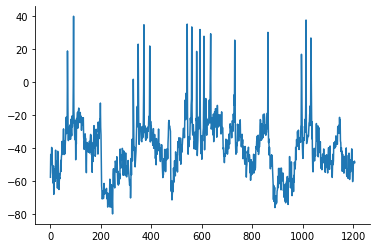

In [28]:
##rescale between [a,b]
a=-80; b=40;
observation_trace['data'] = (b-a)*(observation_trace['data']-min(observation_trace['data']))/(max(observation_trace['data'])-min(observation_trace['data'])) + a
plt.plot(time,observation_trace['data'])

In [29]:
observation_summary_statistics = calculate_summary_statistics(observation_trace,time)

In [30]:
calculate_summary_statistics(observation_trace,time)

array([ 17.        ,   1.0864495 ,   9.        ,   1.11016004,
        32.        ,   1.92965672, -39.60433445,  17.1211649 ,
       293.13428753,   0.84975804,   5.83939317,  17.24265964])

In [31]:
observation_summary_statistics

array([ 17.        ,   1.0864495 ,   9.        ,   1.11016004,
        32.        ,   1.92965672, -39.60433445,  17.1211649 ,
       293.13428753,   0.84975804,   5.83939317,  17.24265964])

In [32]:
#observation_trace = run_HH_model(true_params)
#observation_summary_statistics = calculate_summary_statistics(observation_trace)

Text(0, 0.5, 'input')

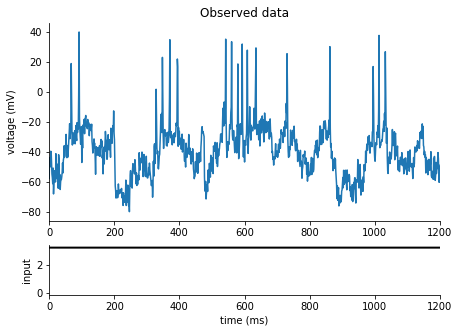

In [33]:
fig = plt.figure(figsize=(7, 5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
plt.plot(observation_trace["time"], observation_trace["data"])
plt.ylabel("voltage (mV)")
plt.title("Observed data")
plt.xlim([0,1200])
#plt.setp(ax, xticks=[], yticks=[-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(observation_trace["time"], I, "k", lw=2)
plt.xlim([0,1200])
plt.xlabel("time (ms)")
plt.ylabel("input")


# ax.set_xticks([0, max(observation_trace["time"]) / 2, max(observation_trace["time"])])
# ax.set_yticks([0, 1.1 * np.max(I * A_soma * 1e3)])
# ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))

In [34]:
## posterior given the observed data
samples = posterior.sample((1000,), x=observation_summary_statistics)

# samples = posterior.sample((10000,), x=observation_summary_statistics)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

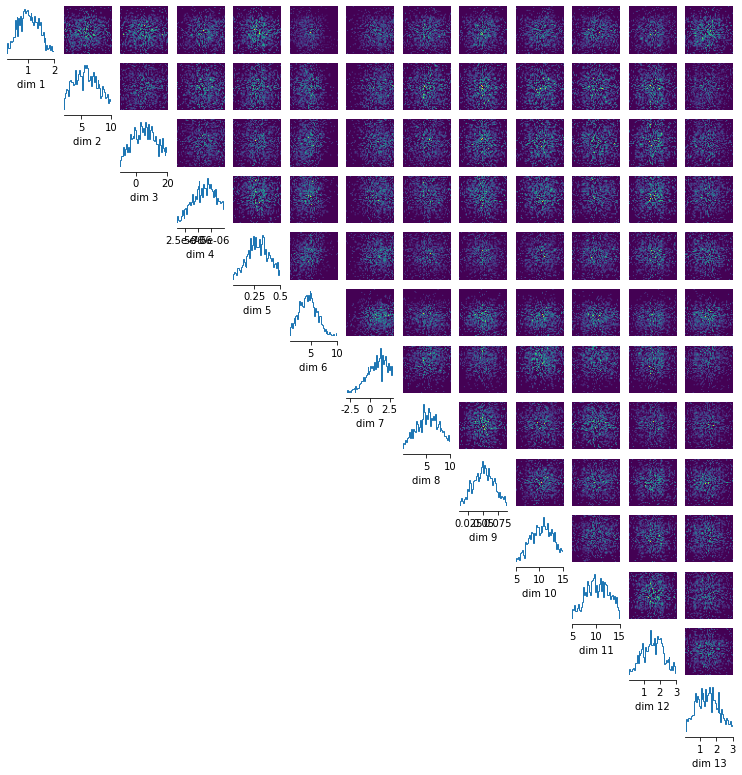

In [35]:
#Na,K,M,Leak,noise


fig, axes = analysis.pairplot(
    samples,
    limits = [[prior_min[0], prior_max[0]], [prior_min[1], prior_max[1]], [prior_min[2], prior_max[2]],[prior_min[3], prior_max[3]], [prior_min[4], prior_max[4]], [prior_min[5], prior_max[5]], [prior_min[6], prior_max[6]],
              [prior_min[7], prior_max[7]], [prior_min[8], prior_max[8]], [prior_min[9], prior_max[9]], [prior_min[10], prior_max[10]], [prior_min[11], prior_max[11]], [prior_min[12], prior_max[12]]],
    # limits=[[0.5, 80], [1e-4, 15.0],[0,1.5],[0,1.5],[0,1.5]],
    # ticks=[[0.5, 80,0], [1e-4, 15.0],[0,1.5],[0,1.5],[0,1.5]],
    figsize=(13, 13),
    # points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
);

In [36]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=observation_summary_statistics).numpy()


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

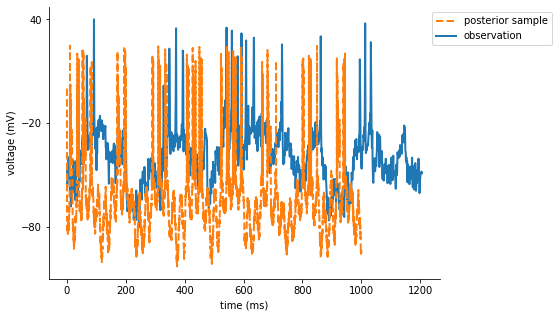

In [37]:
fig = plt.figure(figsize=(7, 5))

# plot observation
# t = observation_trace["time"]
y_obs = observation_trace["data"]
plt.plot(observation_trace["time"], y_obs, lw=2, label="observation")

# simulate and plot samples
x = run_HH_model(posterior_sample)
dt=0.1
t = np.arange(0, duration + dt, dt)
plt.plot(t,x["data"], "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

# ax.set_xticks([0, 60, 120])
ax.set_yticks([-80, -20, 40]);

(0.0, 400.0)

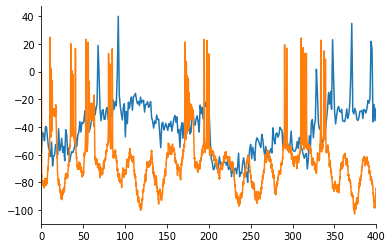

In [42]:
plt.plot(observation_trace["time"], y_obs)
plt.plot(t, x["data"])
plt.xlim([00,400])

In [43]:
posterior_sample

array([[1.0171900e+00, 7.2185535e+00, 6.7499566e+00, 7.9445854e-06,
        1.9331062e-01, 3.1190593e+00, 1.7211655e+00, 6.9979157e+00,
        4.6259012e-02, 6.5905881e+00, 1.1145388e+01, 1.7140535e+00,
        2.4756320e+00]], dtype=float32)

In [44]:
observation_summary_statistics

array([ 17.        ,   1.0864495 ,   9.        ,   1.11016004,
        32.        ,   1.92965672, -39.60433445,  17.1211649 ,
       293.13428753,   0.84975804,   5.83939317,  17.24265964])

In [45]:
calculate_summary_statistics(x)

array([ 66.        ,   1.60495192,   2.        ,   0.        ,
        77.        ,   1.93812178, -65.34404602,  18.02529348,
       324.91120487,   1.33932219,   6.73735892,  22.97882064])